# Isolated SPT2349 Realization

We want to know how the stellar mass in an SPT2349-like system grows over the first $1 \mathrm{Gyr}$ of its evolution.  We produced initial conditions using MAKEGALAXY, and spliced together $14$ galaxies. They had an initial stellar mass, but we allowed stars to form out of gas using the MUFASA models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import seaborn as sb
from matplotlib.backends.backend_pdf import PdfPages

plt.style.use('seaborn-ticks')
plot_style = {'axes.axisbelow': True,
             'axes.edgecolor': '0',
             'axes.facecolor': 'white',
             'axes.grid': False,
             'axes.labelcolor': '.15',
             'axes.spines.bottom': True,
             'axes.spines.left': True,
             'axes.spines.right': True,
             'axes.spines.top': True,
             'figure.facecolor': 'white',
             'font.family': ['DejaVu Serif'],
             'font.serif': ['Times New Roman'],
             'grid.color': '.8',
             'grid.linestyle': '-',
             'image.cmap': 'rocket',
             'lines.solid_capstyle': 'round',
             'lines.linewidth': 2.5,
             'patch.edgecolor': 'w',
             'patch.force_edgecolor': True,
             'text.color': '.15',
             'xtick.bottom': True,
             'xtick.color': '.15',
             'xtick.direction': 'in',
             'xtick.top': True,
             'ytick.color': '.15',
             'ytick.direction': 'in',
             'ytick.left': True,
             'ytick.right': True}

linewidth = 2
axes_fontsize = 12
figsize = (5, 7.2)
dpi = 120

sb.set_style(plot_style)
palette = sb.color_palette('plasma', 4)

#palette = sb.color_palette('colorblind', 10)

In [2]:
max_snap = 102
snaps = np.arange(0, max_snap)

def snap2time(snapnum):
    unit_time = 978.028 # In Myr
    dt = 0.01 # Time between snapshots
    myr_to_gyr = 1.0e-3

    return snapnum * dt * unit_time * myr_to_gyr

times_for_plot = snap2time(snaps[0:max_snap])
real_times = snap2time(snaps[1:max_snap])
delta_time = (snap2time(snaps[1:]) - snap2time(snaps[:-1])) * 1e9  # To yr for Msun/yr
new_times = np.linspace(0, 2, 1000)

In [3]:
clash_masses = np.loadtxt('clash_clusters.txt', skiprows = 1)
clash_masses *= 1e11  # This is the conversion to Msun from their table units

x_values = 0.99 * np.ones(len(clash_masses))

In [4]:
def exponential(t, a, b, c):
    return a * np.exp(-b * t) + c

def get_stellar_info(file_name):
    data = np.loadtxt(file_name, skiprows = 1)
    
    formed_masses = data[:, 0]
    total_masses = data[:, 1]
             
    mass_in_5kpc_a = data[:, 2]
    mass_in_7kpc_a = data[:, 3]
    mass_in_15kpc_a = data[:, 4]
    mass_in_30kpc_a = data[:, 5]
    mass_in_50kpc_a = data[:, 6]
    mass_in_70kpc_a = data[:, 7]
    
    formed_masses = formed_masses[0:max_snap]
    total_masses = total_masses[0:max_snap]
    mass_in_5kpc_a = mass_in_5kpc_a[0:max_snap]
    mass_in_7kpc_a = mass_in_7kpc_a[0:max_snap]
    mass_in_15kpc_a = mass_in_15kpc_a[0:max_snap]
    mass_in_30kpc_a = mass_in_30kpc_a[0:max_snap]
    mass_in_50kpc_a = mass_in_50kpc_a[0:max_snap]
    mass_in_70kpc_a = mass_in_70kpc_a[0:max_snap]

    snaps = np.arange(0, max_snap)

    sfr = (formed_masses[1:] - formed_masses[:-1]) / delta_time
    sfr[np.where(sfr <= 0)] = 1e-20

    real_sfrs = sfr[0:max_snap]

    popt, pcov = curve_fit(exponential, real_times, real_sfrs, p0 = (1e3, 4, 0))
    new_sfrs = exponential(new_times, *popt)

    return {'Total': total_masses, 
            '5kpc': mass_in_5kpc_a,
            '7kpc': mass_in_7kpc_a,
            '15kpc': mass_in_15kpc_a,
            '30kpc': mass_in_30kpc_a, 
            '50kpc': mass_in_50kpc_a, 
            '70kpc': mass_in_70kpc_a, 
            'SFR': real_sfrs,
            'SFR_new': new_sfrs,
            'SFR_fit': popt}

def get_assembly_time(avg_total_masses):
    final_mass = np.amax(avg_total_masses)
    final_mass_90 = 0.9 * final_mass
    mass_idx_90 = np.abs(avg_total_masses - final_mass_90).argmin()

    return snap2time(mass_idx_90)

In [5]:
real01_data = get_stellar_info('SPT2349_1e6_real01_star_mass_data.txt')
#real02_data = get_stellar_info('SPT2349_1e6_real02_star_mass_data.txt')
#real03_data = get_stellar_info('SPT2349_1e6_real03_star_mass_data.txt')
gf05_data = get_stellar_info('SPT2349_1e6_gf0.5_star_mass_data.txt')
gf09_data = get_stellar_info('SPT2349_1e6_gf0.9_star_mass_data.txt')

## SFR of the system

We expect huge amounts of star formation early in the simulation since the systems are ramming into each other at high velocities. There will be some minimal numerical collapse, that will also form stars. SPT2349 itself forms stars at a rate of about $R_\mathrm{sfr} \sim 6\times10^3 \, \mathrm{M}_\mathrm{\odot} \, \mathrm{yr}^{-1}$.

Here we plot the SFR as a function of time, and also fit a decaying exponential to the curve.

In [6]:
print('Average')
print(real01_data['SFR_fit'])

Average
[ 2416.16081049     3.60783289   -94.50336016]


At what time is 90% of the mass assembled?

In [7]:
print('Average Assembly [Gyr]:')
print(get_assembly_time(real01_data['Total']))

Average Assembly [Gyr]:
0.36187036


In [8]:
sfr_at_1gyr = real01_data['SFR'][-2]
sfr_at_1gyr

9.9999999999999995e-21

In [9]:
print('Final Stellar Mass')
print('%g Msun' % real01_data['Total'][-1])

Final Stellar Mass
8.04111e+11 Msun


In [10]:
print('Initial Stellar Mass')
print('%g Msun' % real01_data['50kpc'][0])

Initial Stellar Mass
8.02475e+10 Msun


In [11]:
print('Fraction of 5kpc')
print('%g' % float(real01_data['5kpc'][-1] / real01_data['Total'][-1]))

Fraction of 5kpc
0.705705


In [12]:
print('Fraction of 15kpc')
print('%g' % float(real01_data['15kpc'][-1] / real01_data['Total'][-1]))

Fraction of 15kpc
0.893098


In [19]:
print('Fraction of 50kpc')
print('%g' % float(real01_data['50kpc'][5] / real01_data['Total'][5]))

Fraction of 50kpc
0.958768


## Quick test of gas fractions

I need to test a smaller and higher gas fraction for the referee. When was the mass assembled in these cases? What is the star formation rate fit?

In [18]:
print('Average')
print(gf09_data['SFR_fit'])
print()

print('Average Assembly')
print(get_assembly_time(gf09_data['Total']))
print()

print('Final Stellar Mass')
print('%g Msun' % gf09_data['Total'][-1])

print('Fraction of 5kpc')
print('%g' % float(gf09_data['5kpc'][-1] / gf09_data['50kpc'][-1]))

print('Fraction of 15kpc')
print('%g' % float(gf09_data['15kpc'][-1] / gf09_data['50kpc'][-1]))

print('Fraction of 50kpc')
print('%g' % float(gf09_data['50kpc'][-1] / gf09_data['Total'][-1]))

Average
[ 5566.00053789    19.98658768    30.34957337]

Average Assembly
0.11736336

Final Stellar Mass
3.28715e+11 Msun
Fraction of 5kpc
0.48532
Fraction of 15kpc
0.858998
Fraction of 50kpc
0.835131


In [15]:
print('Average')
print(gf05_data['SFR_fit'])
print()

print('Average Assembly')
print(get_assembly_time(gf05_data['Total']))
print()

print('Final Stellar Mass')
print('%g Msun' % gf05_data['Total'][-1])

print('Fraction of 5kpc')
print('%g' % float(gf05_data['5kpc'][-1] / gf05_data['Total'][-1]))

print('Fraction of 15kpc')
print('%g' % float(gf05_data['15kpc'][-1] / gf05_data['Total'][-1]))

print('Fraction of 50kpc')
print('%g' % float(gf05_data['50kpc'][-1] / gf05_data['Total'][-1]))

Average
[ 3848.98385669     5.39263762  -149.53583111]

Average Assembly
0.1467042

Final Stellar Mass
1.18833e+12 Msun
Fraction of 5kpc
0.63688
Fraction of 15kpc
0.889921
Fraction of 50kpc
0.996449


# Plot Averaged Data

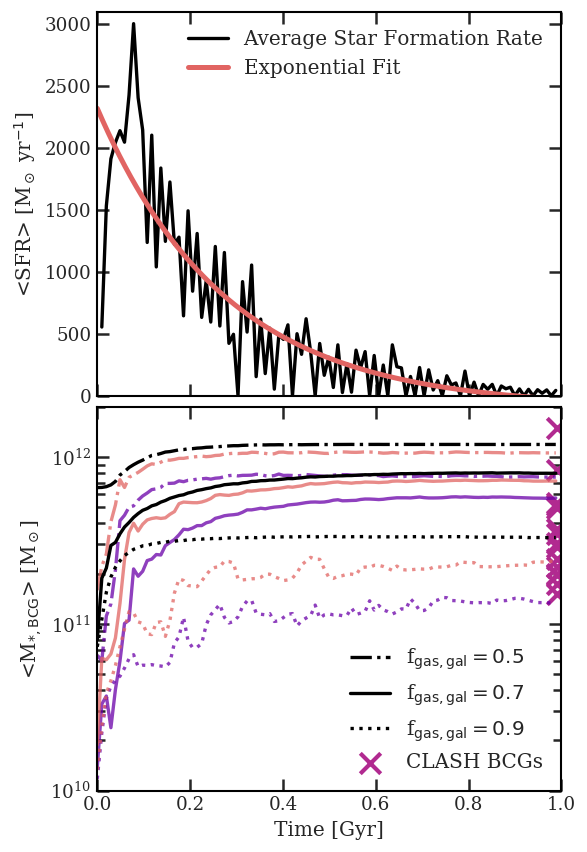

In [16]:
pdf_page = PdfPages('stellar_assembly.pdf')

fig, axes = plt.subplots(figsize = figsize, dpi = dpi, facecolor = 'w', nrows = 2, ncols = 1, sharex = True)

axes[0].set_xlabel('')
axes[0].set_ylabel('<SFR> [M$_\odot$ yr$^{-1}$]', fontsize = axes_fontsize)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 3100])

axes[0].plot(real_times, real01_data['SFR'][0:max_snap - 1], c = 'k', label = 'Average Star Formation Rate', lw = linewidth)

axes[0].plot(new_times, real01_data['SFR_new'], 
             c = palette[2], 
             label = r'Exponential Fit' % (1.0 / real01_data['SFR_fit'][1]), 
             lw = 3)

axes[0].legend(loc = 'upper right', fontsize = axes_fontsize)

axes[1].set_xlabel('Time [Gyr]', fontsize = axes_fontsize)
axes[1].set_ylabel('<M$_\mathrm{*,BCG}$> [M$_\odot$]', fontsize = axes_fontsize)
axes[1].set_yscale('log')
axes[1].set_ylim([1e10, 2e12])

# f_gas = 0.5
axes[1].plot(times_for_plot, gf05_data['Total'][0:max_snap], 
             c = 'k', 
             lw = linewidth, 
             ls = '-.',
             label = r'f$_\mathrm{gas,gal} = 0.5$')
axes[1].plot(times_for_plot, gf05_data['5kpc'][0:max_snap], 
             c = palette[0], 
             lw = linewidth, 
             ls = '-.',
             alpha = 0.75)
axes[1].plot(times_for_plot, gf05_data['15kpc'][0:max_snap], 
             c = palette[2], 
             lw = linewidth, 
             ls = '-.',
             alpha = 0.75)

#axes[1].plot(times_for_plot, gf05_data['50kpc'][0:max_snap], 
#             c = palette[1], 
#             lw = linewidth, 
#             ls = '-.',
#             alpha = 0.75)

# f_gas = 0.7
axes[1].plot(times_for_plot, real01_data['50kpc'][0:max_snap], 
             c = 'k', 
             lw = linewidth,
             label = r'f$_\mathrm{gas,gal} = 0.7$')
axes[1].plot(times_for_plot, real01_data['5kpc'][0:max_snap], 
             c = palette[0], 
             lw = linewidth,
             alpha = 0.75)
axes[1].plot(times_for_plot, real01_data['15kpc'][0:max_snap], 
             c = palette[2], 
             lw = linewidth,
             alpha = 0.75)
#axes[1].plot(times_for_plot, real01_data['50kpc'][0:max_snap], 
#             c = palette[1], 
#             lw = linewidth,
#             alpha = 0.75)

# f_gas = 0.9
axes[1].plot(times_for_plot, gf09_data['Total'][0:max_snap], 
             c = 'k', 
             lw = linewidth,
             ls = ':',
             label = r'f$_\mathrm{gas,gal} = 0.9$')
axes[1].plot(times_for_plot, gf09_data['5kpc'][0:max_snap], 
             c = palette[0], 
             lw = linewidth, 
             ls = ':',
             alpha = 0.75)
axes[1].plot(times_for_plot, gf09_data['15kpc'][0:max_snap], 
             c = palette[2], 
             lw = linewidth, 
             ls = ':',
             alpha = 0.75)
#axes[1].plot(times_for_plot, gf09_data['50kpc'][0:max_snap], 
#             c = palette[1], 
#             lw = linewidth, 
#             ls = ':',
#             alpha = 0.75)

axes[1].scatter(x_values, clash_masses, marker = 'x', c = palette[1], s = 150, label = 'CLASH BCGs')


axes[1].legend(loc = 'best', fontsize = axes_fontsize)

for i in range(0, 2):
    axes[i].tick_params(which = 'major', length = 7, width = 1.5)
    axes[i].tick_params(which = 'minor', length = 5, width = 1.5)
    axes[i].tick_params(labelsize = axes_fontsize - 1)

plt.subplots_adjust(hspace = 0)
plt.tick_params(right = True, top = True)
plt.tight_layout(h_pad = 0)
#pdf_page.savefig(fig)
#pdf_page.close()
plt.savefig('stellar_assembly.pdf')
plt.show()
plt.close()

# Stellar Masses within Aperture Diameter

Need to check the stellar masses within an aperture based on various definitions of BCGs masses. Here we include results for $30 \mathrm{kpc}$, $50 \mathrm{kpc}$, and $70 \mathrm{kpc}$ apertures.

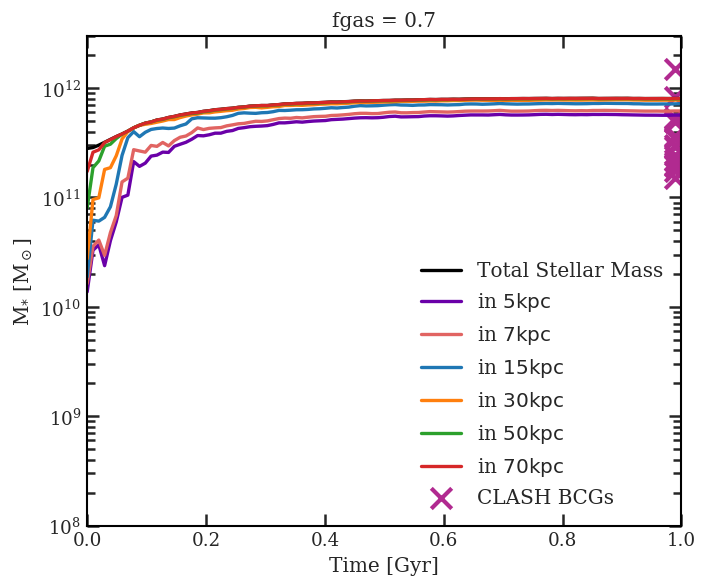

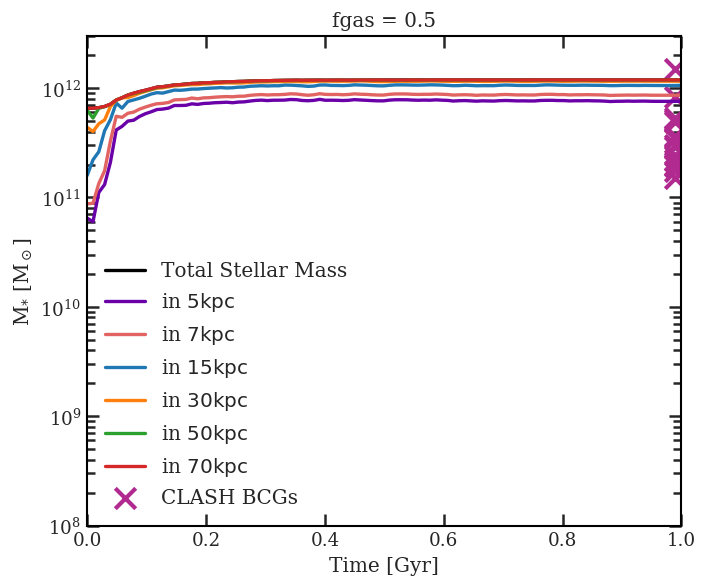

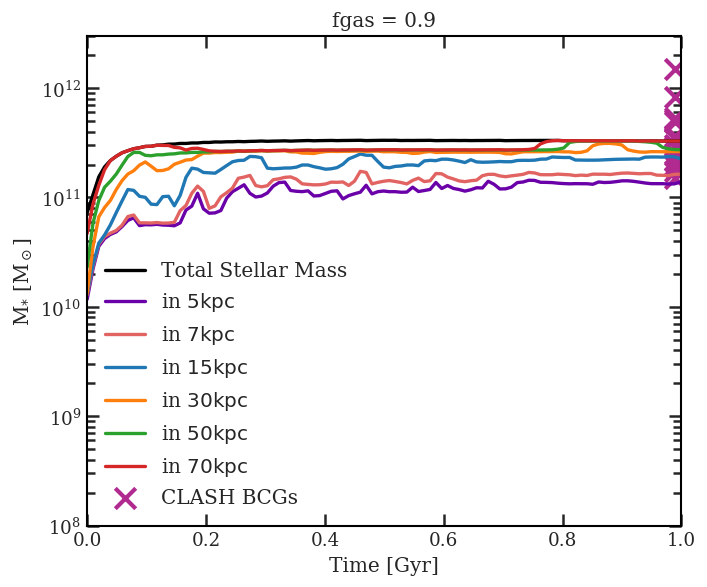

In [17]:
folders_for_plots = ['SPT2349_1e6_real01', 'SPT2349_1e6_gf0.5', 'SPT2349_1e6_gf0.9']

for the_name in folders_for_plots:
    aperture_data = np.loadtxt('%s_star_mass_data.txt' % the_name, skiprows = 1)
    num_snaps = len(aperture_data)

    fig = plt.figure(figsize = (6, 5), dpi = dpi, facecolor = 'w')

    if the_name == 'SPT2349_1e6_real01':
        plt.title('fgas = 0.7')
    elif the_name == 'SPT2349_1e6_gf0.5':
        plt.title('fgas = 0.5')
    else:
        plt.title('fgas = 0.9')
        
    plt.xlabel('Time [Gyr]', fontsize = axes_fontsize)
    plt.ylabel('M$_\mathrm{*}$ [M$_\odot$]', fontsize = axes_fontsize)
    plt.yscale('log')
    plt.xlim([0, 1])
    plt.ylim([1e8, 3e12])
    snap_range = snap2time(np.arange(0, num_snaps))
    plt.plot(snap_range, aperture_data[:, 1], c = 'k', lw = linewidth,
                label = 'Total Stellar Mass')
    plt.plot(snap_range, aperture_data[:, 2], c = palette[0], lw = linewidth,
                label = 'in $5 \mathrm{kpc}$')
    plt.plot(snap_range, aperture_data[:, 3], c = palette[2], lw = linewidth,
                label = 'in $7 \mathrm{kpc}$')
    plt.plot(snap_range, aperture_data[:, 4], lw = linewidth,
                label = 'in $15 \mathrm{kpc}$')
    plt.plot(snap_range, aperture_data[:, 5], lw = linewidth,
                label = 'in $30 \mathrm{kpc}$')
    plt.plot(snap_range, aperture_data[:, 6], lw = linewidth,
                label = 'in $50 \mathrm{kpc}$')
    plt.plot(snap_range, aperture_data[:, 7], lw = linewidth,
                label = 'in $70 \mathrm{kpc}$')
    plt.scatter(x_values, clash_masses, marker = 'x', c = palette[1], s = 150, label = 'CLASH BCGs')

    plt.legend(loc = 'best', fontsize = axes_fontsize)

    ax = plt.gca()

    ax.tick_params(which = 'major', length = 7, width = 1.5)
    ax.tick_params(which = 'minor', length = 5, width = 1.5)
    ax.tick_params(labelsize = axes_fontsize - 1)

    plt.subplots_adjust(hspace = 0)
    plt.tick_params(right = True, top = True)
    plt.tight_layout(h_pad = 0)
    plt.savefig('%s_stellar_mass_with_apertures.pdf' % the_name)
    plt.show()
    plt.close()